# Random Forests

In [39]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("../data/titanic/train.csv")
df_test = pd.read_csv("../data/titanic/test.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
407,408,1,2,"Richards, Master. William Rowe",male,3.0,1,1,29106,18.750,NaN,S
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.000,NaN,S
590,591,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.125,NaN,S
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.250,NaN,S
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.000,NaN,S


In [6]:
def proc_data(df):
    # in place
    df['Fare'] = df.Fare.fillna(0)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(df_test)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
 12  LogFare      891 non-null    float64 
dtypes: category(2), float64(3), int64(5), object(3)
memory usage: 78.7+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          332 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    object  
 8   Fare         418 non-null    float64 
 9   Cabin        91 non-null     object  
 10  Embarked     418 non-null    category
 11  LogFare      418 non-null    float64 
dtypes: category(2), float64(3), int64(4), object(3)
memory usage: 33.8+ KB


In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [10]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

In [11]:
# group variables
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = ['Survived']

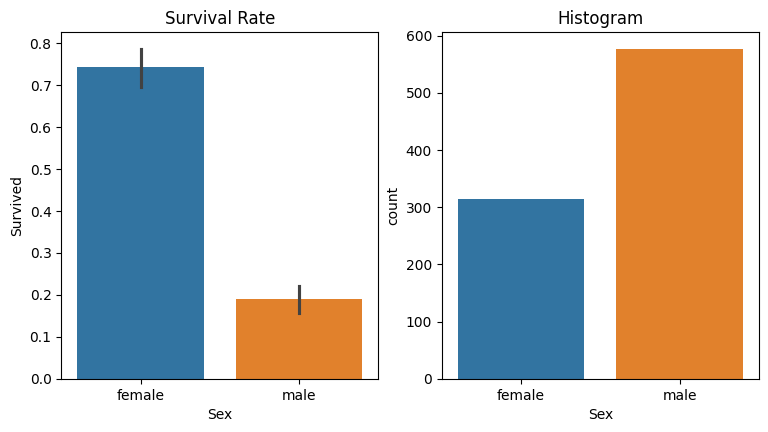

In [12]:
# plot gender vs survival rate and histogram
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
sns.barplot(data=df, x='Sex', y='Survived', hue='Sex', ax=axes[0])
axes[0].set(title="Survival Rate")
sns.countplot(data=df, x='Sex', hue='Sex', ax=axes[1])
axes[1].set(title="Histogram")
fig.show()

In [13]:
np.random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
print(trn_df.shape, val_df.shape)

(668, 13) (223, 13)


In [14]:
# change categorical variables as code
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [15]:
trn_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
755,756,1,2,"Hamalainen, Master. Viljo",1,0.67,1,1,250649,14.5000,NaN,2,2.740840
644,645,1,3,"Baclini, Miss. Eugenie",0,0.75,2,1,2666,19.2583,NaN,0,3.008565
364,365,0,3,"O'Brien, Mr. Thomas",1,NaN,1,0,370365,15.5000,NaN,1,2.803360
317,318,0,2,"Moraweck, Dr. Ernest",1,54.00,0,0,29011,14.0000,NaN,2,2.708050
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",1,18.00,0,0,236171,13.0000,NaN,2,2.639057


In [16]:
val_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
620,621,0,3,"Yasbeck, Mr. Antoni",1,27.0,1,0,2659,14.4542,NaN,0,2.737881
477,478,0,3,"Braund, Mr. Lewis Richard",1,29.0,1,0,3460,7.0458,NaN,2,2.085150
39,40,1,3,"Nicola-Yarred, Miss. Jamila",0,14.0,1,0,2651,11.2417,NaN,0,2.504848
796,797,1,1,"Leader, Dr. Alice (Farnham)",0,49.0,0,0,17465,25.9292,D17,2,3.293211
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",1,20.5,0,0,A/5 21173,7.2500,NaN,2,2.110213


In [17]:
def xs_y(df):
    xs = df[cats+conts].copy()
    y = df[dep].copy()
    return xs, y

In [18]:
trn_xs, trn_y = xs_y(trn_df)

In [19]:
print(trn_xs.shape, trn_y.shape)

(668, 7) (668, 1)


In [20]:
val_xs, val_y = xs_y(val_df)

In [21]:
print(val_xs.shape, val_y.shape)

(223, 7) (223, 1)


In [22]:
# simple predict, survived if sex == 0 (female)
preds = val_xs.Sex == 0

In [23]:
mean_absolute_error(val_y, preds)

0.21524663677130046

In [24]:
# check logfare
trn_df.LogFare.describe()

count    668.000000
mean       2.945562
std        0.981843
min        0.000000
25%        2.188856
50%        2.734368
75%        3.449988
max        6.240917
Name: LogFare, dtype: float64

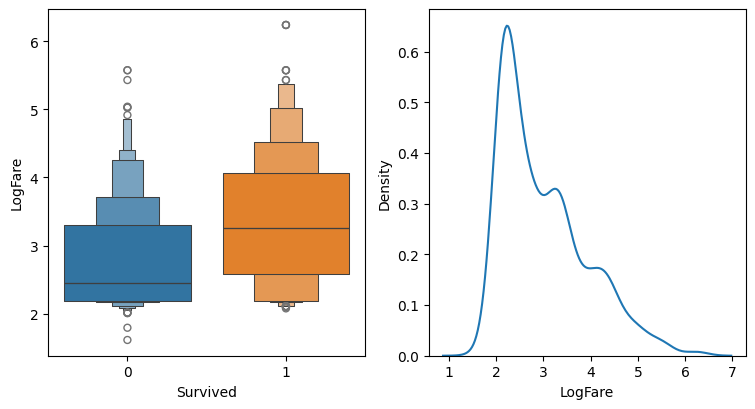

In [25]:
# only take LogFare > 0
df_fare = trn_df[trn_df.LogFare > 0]
fix, axes = plt.subplots(1,2, figsize=(9, 4.5))
sns.boxenplot(data=df_fare, x='Survived', y='LogFare', hue='Survived', ax=axes[0])
axes[0].get_legend().remove()
sns.kdeplot(data=df_fare, x='LogFare', ax=axes[1])
fig.show()

In [26]:
# a function that calcualte side score
def _side_score(side, y):
    # side:ndarray[bool]
    # y: ndarray
    tot = side.sum()
    if tot <= 1: return 0
    return y[side].std()*tot  # will be used to calcualte the weighted average

In [27]:
def score(col, y, split):
    # col: pd.series
    # y: ndarray
    # split: float
    lhs = col <= split
    return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [28]:
# test score
score(trn_xs['Sex'], trn_y, 0.5)

Survived    0.407875
dtype: float64

In [29]:
score(trn_xs['LogFare'], trn_y, 2.7)

Survived    0.471809
dtype: float64

## What is the score

The score we calculate is the weighted average of the **standard deviation** target variable `y` for two different groups. Ideally, we want to our score as low as possible since this will give us a better split. This means that we want to have groups that should be different from each other.

In [30]:
def iscore(cols, split):
    col_data = trn_xs[cols]
    return score(col_data, trn_y, split)

In [31]:
from ipywidgets import interact
interact(cols=conts, split=10)(iscore);

interactive(children=(Dropdown(description='cols', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), val…

In [32]:
from ipywidgets import interact
interact(cols=cats, split=2)(iscore);

interactive(children=(Dropdown(description='cols', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=…

## How to find the best split?

We can first sort the column and loop over the rows and find the cutoff point where we could have the lowest score.

In [33]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    # get the idx for the lowest score
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, array([0.47831672]))

In [35]:
# get all columns
cols = cats + conts
{c:min_col(trn_df, c) for c in cols}

{'Sex': (0, array([0.40787531])),
 'Embarked': (0, array([0.4780752])),
 'Age': (6.0, array([0.47831672])),
 'SibSp': (4, array([0.47837403])),
 'Parch': (0, array([0.48052965])),
 'LogFare': (2.4390808375825834, array([0.46208239])),
 'Pclass': (2, array([0.46048262]))}

As you can see that we have the best split for column `sex` when `sex = 0`. How could split the other columns? We will basically follow the number we have already calculated. But what about the order of the columns?

## Building a decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [37]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

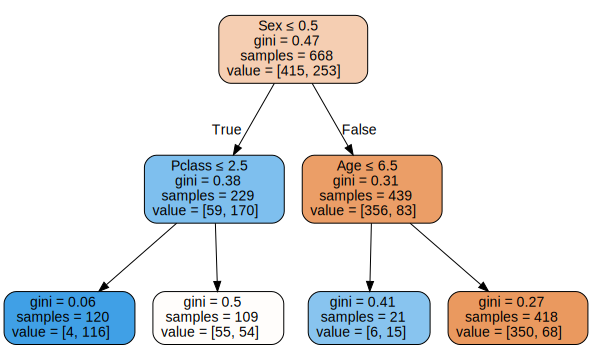

In [40]:
# since we set max_leaf_nodes = 4, then we only have 3 leves of tree
draw_tree(m, trn_xs, size=10)

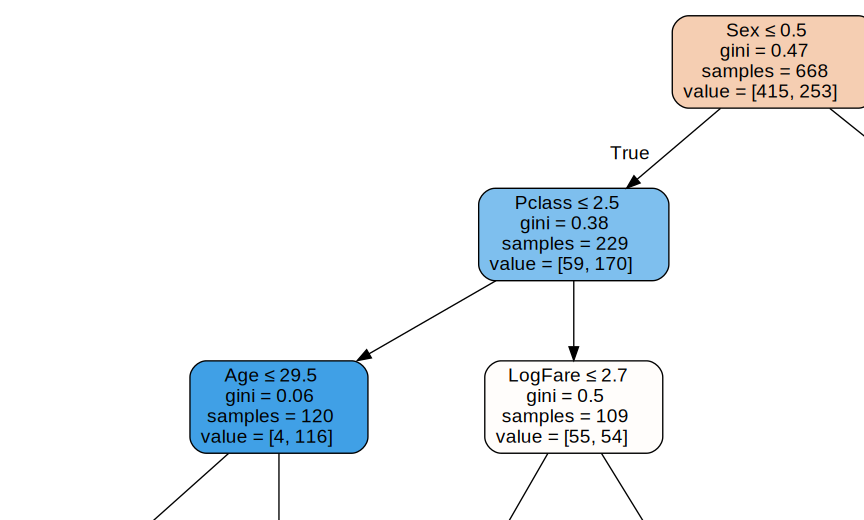

In [41]:
# we can set min_samples_leaf
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)